# Bio_ClinicalBERT approach for detecting rare diseases

This notebook contains the code to develop a Bio_ClinicalBERT model to detect rare diseases from texts, which is BERT model pre trained on a huge corpus of medical data (from there, the prefix 'Bio_Clinical').

The Bio_ClinicalBERT model was trained on all notes from [MIMIC III](https://www.nature.com/articles/sdata201635), a database containing electronic health records from ICU patients at the Beth Israel Hospital in Boston, MA. For more details on MIMIC, see [here](https://mimic.physionet.org/). All notes from the NOTEEVENTS table were included (~880M words).

The Bio_ClinicalBERT model was trained using code from [Google's BERT repository](https://github.com/google-research/bert) on a GeForce GTX TITAN X 12 GB GPU. Model parameters were initialized with BioBERT (BioBERT-Base v1.0 + PubMed 200K + PMC 270K).

To accomplish this, we will use some tools developed in the [transformers](https://huggingface.co/transformers/index.html) library, which is a library that recopiles some of the State-of-the-art Natural Language Processing for Pytorch and TensorFlow.

To make use of the pre-trained model with the hugging face `transformers` library, we need the model's weights to be in a form which pyTorch understands. The original model was trained using tensorflow so we need to convert the weights into pyTorch weights. We can then import and use it.

In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    #drive.flush_and_unmount()
    drive.mount('/content/drive')
    root = '/content/drive/My Drive/Colab Notebooks'
else:
    print('Not running on CoLab')
    root = './'

print("Current directory: {}".format(root))

Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current directory: /content/drive/My Drive/Colab Notebooks


## 1. Getting the resources

First of all, we will download the model from github repo of [Bio_ClinicalBert](https://github.com/EmilyAlsentzer/clinicalBERT).

After that, we will install the needed packages.

In [ ]:
!pip install pytorch_transformers
!pip install transformers
!pip install seqeval
!pip install sklearn-crfsuite
!pip install keras_preprocessing
# !pip install numpy --upgrade
!pip install --force-reinstall --no-dependencies "scikit-learn==0.24.2"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-0.24.2-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


The pretrained `Bio_ClinicalBERT` model can be obtained both from a direct download [here](https://www.dropbox.com/s/8armk04fu16algz/pretrained_bert_tf.tar.gz?dl=0) or loading it directly from the `transformers library`, which is the way used in this notebook.

## 2. Data loading and first insights

In this step we will download the data and define all of the main paths that our model includes.

It is also possible to select the desired language (`en` for english and `es` for spanish) and whether to consider all the entities from the model or not (`allTypes` variable).

In [ ]:
LANG = 'en'  #This system will also process texts written in Spanish, LANG='es'
allTypes = True
sTypes = ''
if allTypes:
    sTypes = '_all'

#path_data=root+'data/{}/'.format(LANG) #folder where you can find the datasets
path_data = root + '/ner/data/gold_nlp4rare_corpus_new/' #folder where you can find the datasets
path_models = root + '/ner/models/{}/'.format(LANG) #folder to save the models
checkpoints = root + '/ner/checkpoints/'
path_scores = root + '/ner/scores/{}/'.format(LANG) #folder to save the scores
path_outputs = root + '/ner/outputs/{}/'.format(LANG) #folder to save the scores

print('Datasets:',path_data)
print('Path to save this model:',path_models)
print('Path for checkpoints:',checkpoints)
print('Path to save the scores:',path_scores)
print('Path to save the outputs:',path_outputs)

Datasets: /content/drive/My Drive/Colab Notebooks/ner/data/gold_nlp4rare_corpus_new/
Path to save this model: /content/drive/My Drive/Colab Notebooks/ner/models/en/
Path for checkpoints: /content/drive/My Drive/Colab Notebooks/ner/checkpoints/
Path to save the scores: /content/drive/My Drive/Colab Notebooks/ner/scores/en/
Path to save the outputs: /content/drive/My Drive/Colab Notebooks/ner/outputs/en/


In [ ]:
import pandas as pd

df_train = pd.read_csv(path_data+'train{}.csv'.format(sTypes),index_col=0)
print('size of the training dataset: {}'.format(len(df_train)))
df_dev = pd.read_csv(path_data+'dev{}.csv'.format(sTypes),index_col=0)
print('size of the development dataset: {}'.format(len(df_dev)))
df_test = pd.read_csv(path_data+'test{}.csv'.format(sTypes),index_col=0)
print('size of the test dataset: {}'.format(len(df_test)))
print('datasets loaded!\n')

#number of labels (IOB tags)
tags = df_train['Tag'].unique()
num_tags = df_train['Tag'].nunique()
print('Labels: {}'.format(tags))
print('Nr of labels: {}'.format(num_tags))

# Overall statistics for the number of words in each text
count_df_train = df_train.groupby('Sentence #').count()
statistics_train = count_df_train['Word'].describe()
print('\nSome statistics of the sentences in the training dataset:')
print(statistics_train)

count_df_dev = df_dev.groupby('Sentence #').count()
statistics_dev = count_df_dev['Word'].describe()
print('\nSome statistics of the sentences in the development dataset:')
print(statistics_dev)

count_df_test = df_test.groupby('Sentence #').count()
statistics_test = count_df_test['Word'].describe()
print('\nSome statistics of the sentences in the developmtestent dataset:')
print(statistics_test)

#The lenth of the longest sentence. Lenght is the number of words.
MAX_LEN_TRAIN = int(statistics_train['max'])
MAX_LEN_DEV = int(statistics_dev['max'])
MAX_LEN_TEST = int(statistics_test['max'])
MAX_LEN = max(MAX_LEN_TRAIN, MAX_LEN_DEV, MAX_LEN_TEST)
print('\n')
print('The maximum length of sentences in TRAIN is: ', MAX_LEN_TRAIN)
print('The maximum length of sentences in DEV is: ', MAX_LEN_DEV)
print('The maximum length of sentences in TEST is: ', MAX_LEN_TEST)
print('The maximum length of sentences in TOTAL is:', MAX_LEN)

size of the training dataset: 121981
size of the development dataset: 15188
size of the test dataset: 16979
datasets loaded!

Labels: ['O' 'B-RAREDISEASE' 'I-RAREDISEASE' 'B-DISEASE' 'I-DISEASE' 'B-SIGN'
 'I-SIGN' 'B-SYMPTOM' 'I-SYMPTOM']
Nr of labels: 9

Some statistics of the sentences in the training dataset:
count    5272.000000
mean       22.915971
std        12.734999
min         1.000000
25%        14.000000
50%        20.000000
75%        29.000000
max       145.000000
Name: Word, dtype: float64

Some statistics of the sentences in the development dataset:
count    723.000000
mean      20.786999
std       10.638559
min        2.000000
25%       13.000000
50%       18.000000
75%       26.000000
max       68.000000
Name: Word, dtype: float64

Some statistics of the sentences in the developmtestent dataset:
count    808.000000
mean      20.820545
std       10.866942
min        1.000000
25%       13.000000
50%       18.000000
75%       26.000000
max       78.000000
Name: Word, dtyp

We visualize next the distribution of each of the datasets according to its entities.

In [ ]:
separator = '*'*60
# Tag statistics train df
print('TRAIN:\n', df_train['Tag'].value_counts(), sep='\n', end='\n')
print()
print('Percentages:', df_train['Tag'].value_counts(normalize=True)*100, sep='\n', end='\n')

# Tag statistics dev df
print('', separator, '', sep='\n')
print('DEV:\n', df_dev['Tag'].value_counts(), sep='\n', end='\n')
print()
print('Percentages:', df_dev['Tag'].value_counts(normalize=True)*100, sep='\n', end='\n')

# Tag statistics test df
print('', separator, '', sep='\n')
print('TEST:\n', df_test['Tag'].value_counts(), sep='\n', end='\n')
print()
print('Percentages:', df_test['Tag'].value_counts(normalize=True)*100, sep='\n', end='\n')

TRAIN:

O                102044
I-SIGN             6915
I-RAREDISEASE      3801
B-RAREDISEASE      3234
B-SIGN             2590
I-DISEASE          1501
B-DISEASE          1407
B-SYMPTOM           245
I-SYMPTOM           244
Name: Tag, dtype: int64

Percentages:
O                83.655651
I-SIGN            5.668916
I-RAREDISEASE     3.116059
B-RAREDISEASE     2.651233
B-SIGN            2.123281
I-DISEASE         1.230520
B-DISEASE         1.153458
B-SYMPTOM         0.200851
I-SYMPTOM         0.200031
Name: Tag, dtype: float64

************************************************************

DEV:

O                12596
I-SIGN             943
I-RAREDISEASE      505
B-RAREDISEASE      402
B-SIGN             315
I-DISEASE          226
B-DISEASE          165
B-SYMPTOM           25
I-SYMPTOM           11
Name: Tag, dtype: int64

Percentages:
O                82.933895
I-SIGN            6.208849
I-RAREDISEASE     3.324993
B-RAREDISEASE     2.646826
B-SIGN            2.074006
I-DISEASE         1.

## 3. Imports and pre-processing of the data

First, all the steps to import the necessary packages to use the model are defined. After that, the pre processing of the data is necessary as the `Bert` model need to meet some special requirements.

In [ ]:
!pip install numpy --upgrade
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertForSequenceClassification
from pytorch_pretrained_bert import BertAdam
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
#% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'Tesla T4'

The model does not process text, so we need to transform all the pre-defined entities (labels) to a language that can be interpreted by the model, i.e., numbers.

To do that, we create a dictionary with the desired labels following the IOB scheme.

In [ ]:
# We have to create a dictionary for the labels (IOB labels):
# label is key and value is index.
tag_index = {t : i + 1 for i, t in enumerate(tags)}
#we have to add a new label for pad tokens
tag_index["PAD"] = 0

print('Dictionary for labels:', tag_index)
print('Number of tags added the tag for pad tokens:', len(tag_index))

Dictionary for labels: {'O': 1, 'B-RAREDISEASE': 2, 'I-RAREDISEASE': 3, 'B-DISEASE': 4, 'I-DISEASE': 5, 'B-SIGN': 6, 'I-SIGN': 7, 'B-SYMPTOM': 8, 'I-SYMPTOM': 9, 'PAD': 0}
Number of tags added the tag for pad tokens: 10


Next, we perform the first step of preprocessing of the data. Here, a class `SentenceGetter` in combination to a function `vectorization` are defined to extract the desired features from the input data.

In [ ]:
#from tensorflow.keras.preprocessing.sequence import pad_sequences

class SentenceGetter(object):
    """This is a class to get sentence. Each sentence will be a list of tuples with its words, tag and pos."""
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]

    def get_text(self):
        try:
            #s = self.grouped['Sentence: {}'.format(self.n_sent)]
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

def vectorization(df, tag_index):
    """This functions gets the dataframe with the dataset and transform it to vectors.
    First, its sentences are retrieved. Then, for each sentence, the function creates a list
    with its corresponding indexes. In addition to X (which are the sentences transformed to vectors),
    the functions also returns the corresponding labels for each token"""

    df = df[['Sentence #','Word','POS','Tag']]

    # Getting full sentences
    getter = SentenceGetter(df)
    sentences = getter.sentences

    X = [[w[0] for w in s] for s in sentences]

    # Convert label to index
    y = [[tag_index[w[2]] for w in s] for s in sentences]

    return (X, y)

# vectorization of datasets
sentences_train, labels_train = vectorization(df_train, tag_index)
sentences_dev, labels_dev = vectorization(df_dev, tag_index)
sentences_test, labels_test = vectorization(df_test, tag_index)
print('Datasets loaded!')

Datasets loaded!


Same as for the labels, all of the retrieved words for each sentence is necessary to be converted to numbers to use them in the model. For that, we use the tokenization of the Bert model.

Afterwards, we also load the model to use as the architecture.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", do_lower_case=True)
model = AutoModelForTokenClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=num_tags+1)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

Here, an example of tokenization is provided to check how this process works.

Through this example, we can see how the original sentence is transformed to new subwords or 'tokens', and after that the tokenizer assign them a number according to its internal vocabulary.

As new subwords are created, the original lenght of the sentence is modified. Then, the original labels are no longer valid, and a new processing of the labels is necessary to correct this disalignment between words and labels.

In [ ]:
# Example of BERT tokenization
selected_index = np.random.randint(1, 6461)
# selected_index = 344
# selected_index = 4
selected_sentence = sentences_train[selected_index]
tokenized_input = tokenizer(selected_sentence, is_split_into_words=True, add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print("Sentence used: {}\nOriginal sentence:\n\t{}".format(selected_index, selected_sentence))
print("Tokenization of the sentence:\n\t{}".format(tokens))
print('Tokenized ids for the sentence:\n\t{}'.format(tokenized_input["input_ids"]))
print("Length:\n\tOriginal sentence: {}\n\tTokenized sentence: {}\n\tTokenized ids: {}".format(len(selected_sentence), len(tokens), len(tokenized_input["input_ids"])))

# Example label alignment after BERT tokenization
selected_original_labels = labels_train[selected_index]

print('')
print('Original labels:\n\t{}'.format(selected_original_labels))

word_ids = []
index = 0
current_word = ''
for token in tokens:
    if token.startswith("##"):
        word_ids.append(index-1)
    elif token in current_word:
        if len(tokenizer.tokenize(current_word)) != 1:
            subtokens_qty = len(tokenizer.tokenize(current_word))
            for subtoken in tokenizer.tokenize(current_word):
                if token == subtoken:
                    word_ids.append(index-1)
                    break
                subtokens_qty -= 1
                if subtokens_qty == 0:
                    word_ids.append(index)
                    current_word = selected_sentence[index].lower()
                    index += 1
        else:
            word_ids.append(index)
            current_word = selected_sentence[index].lower()
            index += 1
    else:
        word_ids.append(index)
        current_word = selected_sentence[index].lower()
        index += 1

print('New assigned word_ids:\n\t{}'.format(word_ids))

aligned_labels = []
old_index = -1

if allTypes:
    for i in word_ids:
        if (i == old_index) and ( (selected_original_labels[i] == 2) or (selected_original_labels[i] == 4) or (selected_original_labels[i] == 6) or (selected_original_labels[i] == 8) ):
            aligned_labels.append(selected_original_labels[i]+1)
        else:
            aligned_labels.append(selected_original_labels[i])
        old_index = i
else:
    for i in word_ids:
        if (i == old_index) and ( (selected_original_labels[i] == 2) or (selected_original_labels[i] == 4) ):
            aligned_labels.append(selected_original_labels[i]+1)
        else:
            aligned_labels.append(selected_original_labels[i])
        old_index = i

# print('')
# print('Original labels:\n\t{}'.format(selected_original_labels))
# print('New assigned word_ids:\n\t{}'.format(word_ids))
print('New label alignment:\n\t{}'.format(aligned_labels))
print("Length:\n\tOriginal labels: {}\n\tNew assigned word_ids: {}\n\tNew label alignment: {}".format(len(selected_original_labels), len(word_ids), len(aligned_labels)))

Sentence used: 1850
Original sentence:
	['Although', 'families', 'have', 'been', 'described', 'in', 'which', 'the', 'condition', 'follows', 'autosomal', 'dominant', 'inheritance', ',', 'these', 'families', 'actually', 'have', 'other', 'multifocal', 'venous', 'malformations', '.']
Tokenization of the sentence:
	['although', 'families', 'have', 'been', 'described', 'in', 'which', 'the', 'condition', 'follows', 'auto', '##so', '##mal', 'dominant', 'inheritance', ',', 'these', 'families', 'actually', 'have', 'other', 'multi', '##fo', '##cal', 've', '##nous', 'ma', '##lf', '##orm', '##ations', '.']
Tokenized ids for the sentence:
	[1780, 2073, 1138, 1151, 1758, 1107, 1134, 1103, 3879, 3226, 12365, 7301, 7435, 7065, 13998, 117, 1292, 2073, 2140, 1138, 1168, 4321, 14467, 7867, 1396, 23901, 12477, 9654, 24211, 6006, 119]
Length:
	Original sentence: 23
	Tokenized sentence: 31
	Tokenized ids: 31

Original labels:
	[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 7, 7, 1]
New assigned

In [ ]:
# print(tokenizer.tokenize('1%-2'))
# print(tokenizer.tokenize('and'))
# print(tokenizer.tokenize('NMOSD'))
subtoken_to_analyze = '2'
strings = ['1%-2', 'and', 'with', 'NMOSD', '2,000', ',', '2-2', '222', '24-hour']

for string in strings:
    print('[', string, ']')
    if len(tokenizer.tokenize(string)) != 1:
        print('\t({})'.format(tokenizer.tokenize(string)))
        print('\tnot unique word')
        subtokens_qty = len(tokenizer.tokenize(string))
        for subtoken in tokenizer.tokenize(string):
            if subtoken_to_analyze.lower() == subtoken:
                print('------> <{}> belongs to last word'.format(subtoken_to_analyze))
                break
            subtokens_qty -= 1
            if subtokens_qty == 0:
                print('------> <{}> does NOT belong to last word'.format(subtoken_to_analyze))
    else:
        print('\tunique word')

[ 1%-2 ]
	(['1', '%', '-', '2'])
	not unique word
------> <2> belongs to last word
[ and ]
	unique word
[ with ]
	unique word
[ NMOSD ]
	(['nm', '##os', '##d'])
	not unique word
------> <2> does NOT belong to last word
[ 2,000 ]
	(['2', ',', '000'])
	not unique word
------> <2> belongs to last word
[ , ]
	unique word
[ 2-2 ]
	(['2', '-', '2'])
	not unique word
------> <2> belongs to last word
[ 222 ]
	unique word
[ 24-hour ]
	(['24', '-', 'hour'])
	not unique word
------> <2> does NOT belong to last word


After the example, we proceed with the same operation to the full datasets.

In [ ]:
def align_labels(original_sentences, original_labels, MAX_LEN):
    """
    This function assign the new labels following the original input and according to
    the results from the Tokenization to create a good alignment between words/subwords
    and labels.
    Besides this, it provides the new maximum lenght of the sentences after the Tokenization
    for future padding purposes.
    """
    # After vectorization, some sentences have nan, so need to remove them from the sentences
    # and the corresponding labels
    new_sentences = []
    new_labels = []
    for sentences_, labels_ in zip(original_sentences, original_labels):
      n = []
      v = []
      for sentence, label in zip(sentences_, labels_):
        if not pd.isnull(sentence):
          n.append(sentence)
          v.append(label)
      new_sentences.append(n)
      new_labels.append(v)

    tokenized_input = tokenizer(new_sentences, is_split_into_words=True, add_special_tokens=False)
    tokens = [tokenizer.convert_ids_to_tokens(t) for t in tokenized_input["input_ids"]]
    list_len = [len(i) for i in tokens]
    MAX_LEN = max(max(list_len), MAX_LEN)

    word_ids_global = []
    for nr_sentence, list_tokens in enumerate(tokens):
        word_ids = []
        index = 0
        current_word = ''
        for token in list_tokens:
            if token.startswith("##"):
                word_ids.append(index-1)
            elif token in current_word:
                if len(tokenizer.tokenize(current_word)) != 1:
                    subtokens_qty = len(tokenizer.tokenize(current_word))
                    for subtoken in tokenizer.tokenize(current_word):
                        if token == subtoken:
                            word_ids.append(index-1)
                            break
                        subtokens_qty -= 1
                        if subtokens_qty == 0:
                            word_ids.append(index)
                            current_word = new_sentences[nr_sentence][index].lower()
                            index += 1
                else:
                    word_ids.append(index)
                    current_word = new_sentences[nr_sentence][index].lower()
                    index += 1
            else:
                word_ids.append(index)
                current_word = new_sentences[nr_sentence][index].lower()
                index += 1
        word_ids_global.append(word_ids)

    aligned_global = []
    for nr_sentence, list_word_ids in enumerate(word_ids_global):
        aligned_labels = []
        old_index = -1
        if allTypes:
            for i in list_word_ids:
                if (i == old_index) and ( (new_labels[nr_sentence][i] == 2) or (new_labels[nr_sentence][i] == 4) or (new_labels[nr_sentence][i] == 6) or (new_labels[nr_sentence][i] == 8) ):
                    aligned_labels.append(new_labels[nr_sentence][i]+1)
                else:
                    aligned_labels.append(new_labels[nr_sentence][i])
                old_index = i
        else:
            for i in list_word_ids:
                if (i == old_index) and ( (new_labels[nr_sentence][i] == 2) or (new_labels[nr_sentence][i] == 4) ):
                    aligned_labels.append(new_labels[nr_sentence][i]+1)
                else:
                    aligned_labels.append(new_labels[nr_sentence][i])
                old_index = i
        aligned_global.append(aligned_labels)

    return MAX_LEN, aligned_global

print('Aligning labels...')
train_max_len, aligned_labels_train = align_labels(sentences_train, labels_train, MAX_LEN)
dev_max_len, aligned_labels_dev = align_labels(sentences_dev, labels_dev, MAX_LEN)
test_max_len, aligned_labels_test = align_labels(sentences_test, labels_test, MAX_LEN)
print('Labels aligned!')
CORRECTED_MAX_LEN = max(train_max_len, dev_max_len)
print('New defined MAX_LEN after tokenization is: ', CORRECTED_MAX_LEN)

Aligning labels...
Labels aligned!
New defined MAX_LEN after tokenization is:  190


The pre-processing of the data is finished with the padding of the new labels to the maximum lenght and the tokenization of the words.

In [ ]:
# Padding labels according to corrected MAX_LEN
final_train_labels = pad_sequences(maxlen=CORRECTED_MAX_LEN, sequences=aligned_labels_train, padding="post", value=tag_index["PAD"]).tolist()
final_dev_labels = pad_sequences(maxlen=CORRECTED_MAX_LEN, sequences=aligned_labels_dev, padding="post", value=tag_index["PAD"]).tolist()
final_test_labels = pad_sequences(maxlen=CORRECTED_MAX_LEN, sequences=aligned_labels_test, padding="post", value=tag_index["PAD"]).tolist()
print('Labels padded')

# Tokenize inputs according to corrected MAX_LEN
# train dataset
# After vectorization, some sentences have nan, so need to remove them from the sentences
# and the corresponding labels
sentences_train_new = []
labels_train_new = []
for sentences_, labels_ in zip(sentences_train, labels_train):
  n = []
  v = []
  for sentence, label in zip(sentences_, labels_):
      if not pd.isnull(sentence):
        n.append(sentence)
        v.append(label)
  sentences_train_new.append(n)
  labels_train_new.append(v)

tokenized_input_train = tokenizer(sentences_train_new, truncation=True, max_length=CORRECTED_MAX_LEN, padding='max_length', is_split_into_words=True, add_special_tokens=False)
print('\nTrain dataset:\n\tsentences lenght: {}.\n\tlabels lenght: {}.\n\tinput_ids length: {}.'.format(len(sentences_train_new), len(labels_train_new), len(tokenized_input_train['input_ids'])))

# dev dataset
# After vectorization, some sentences have nan, so need to remove them from the sentences
# and the corresponding labels
sentences_dev_new = []
labels_dev_new = []
for sentences_, labels_ in zip(sentences_dev, labels_dev):
  n = []
  v = []
  for sentence, label in zip(sentences_, labels_):
      if not pd.isnull(sentence):
        n.append(sentence)
        v.append(label)
  sentences_dev_new.append(n)
  labels_dev_new.append(v)

tokenized_input_dev = tokenizer(sentences_dev_new, truncation=True, max_length=CORRECTED_MAX_LEN, padding='max_length', is_split_into_words=True, add_special_tokens=False)
print('\nDev dataset:\n\tsentences lenght: {}.\n\tlabels lenght: {}.\n\tinput_ids length: {}.'.format(len(sentences_dev_new), len(labels_dev_new), len(tokenized_input_dev['input_ids'])))

# test dataset
# After vectorization, some sentences have nan, so need to remove them from the sentences
# and the corresponding labels
sentences_test_new = []
labels_test_new = []
for sentences_, labels_ in zip(sentences_test, labels_test):
  n = []
  v = []
  for sentence, label in zip(sentences_, labels_):
      if not pd.isnull(sentence):
        n.append(sentence)
        v.append(label)
  sentences_test_new.append(n)
  labels_test_new.append(v)
tokenized_input_test = tokenizer(sentences_test_new, truncation=True, max_length=CORRECTED_MAX_LEN, padding='max_length', is_split_into_words=True, add_special_tokens=False)
print('\nTest dataset:\n\tsentences lenght: {}.\n\tlabels lenght: {}.\n\tinput_ids length: {}.'.format(len(sentences_test_new), len(labels_test_new), len(tokenized_input_test['input_ids'])))

Labels padded

Train dataset:
	sentences lenght: 5272.
	labels lenght: 5272.
	input_ids length: 5272.

Dev dataset:
	sentences lenght: 723.
	labels lenght: 723.
	input_ids length: 723.

Test dataset:
	sentences lenght: 808.
	labels lenght: 808.
	input_ids length: 808.


We now extract one example from the processed data to check the dimensions and alignment among all of the inputs.

In [ ]:
# Checking all is right
print(tokenized_input_dev.keys())
print(tokenized_input_dev['input_ids'][0])
print(tokenized_input_dev['attention_mask'][0])
print(final_dev_labels[0])
print('Length inputs: {}.\nLength masks: {}.\nLength labels: {}.'.format(len(tokenized_input_dev['input_ids'][0]), len(tokenized_input_dev['attention_mask'][0]), len(final_dev_labels[0])))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
[1103, 7172, 10950, 3113, 176, 1931, 3370, 22832, 1193, 1415, 1107, 24928, 15590, 9318, 117, 3989, 16320, 1116, 1105, 191, 1548, 14840, 1348, 8006, 119, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## 4. Definition of the model

For reproducibility reasons, we fix a seed for PyTorch and convert all the data into tensors as the model requires.

In [ ]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic=True
batch_size = 32 # 64

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(tokenized_input_train["input_ids"])
train_masks = torch.tensor(tokenized_input_train["attention_mask"])
train_labels = torch.tensor(final_train_labels)

validation_inputs = torch.tensor(tokenized_input_dev["input_ids"])
validation_masks = torch.tensor(tokenized_input_dev["attention_mask"])
validation_labels = torch.tensor(final_dev_labels)

test_inputs = torch.tensor(tokenized_input_test["input_ids"])
test_masks = torch.tensor(tokenized_input_test["attention_mask"])
test_labels = torch.tensor(final_test_labels)

# Checking outputs
print('Train tensor shapes:')
print('Inputs: ', train_inputs.shape)
print('Masks: ', train_masks.shape)
print('Labels: ', train_labels.shape)
print('\nValidation tensor shapes:')
print('Inputs: ', validation_inputs.shape)
print('Masks: ', validation_masks.shape)
print('Labels: ', validation_labels.shape)
print('\nTest tensor shapes:')
print('Inputs: ', test_inputs.shape)
print('Masks: ', test_masks.shape)
print('Labels: ', test_labels.shape)

# Create an iterator of our data with torch DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
shuffled_train_data = torch.utils.data.Subset(train_data, torch.randperm(len(train_data)).tolist())
train_dataloader = DataLoader(shuffled_train_data, batch_size=batch_size, shuffle=False)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
shuffled_validation_data = torch.utils.data.Subset(validation_data, torch.randperm(len(validation_data)).tolist())
validation_dataloader = DataLoader(shuffled_validation_data, batch_size=len(labels_dev), shuffle=False)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
shuffled_test_data = torch.utils.data.Subset(test_data, torch.randperm(len(test_data)).tolist())
test_dataloader = DataLoader(shuffled_test_data, batch_size=len(labels_test), shuffle=False)

Train tensor shapes:
Inputs:  torch.Size([5272, 190])
Masks:  torch.Size([5272, 190])
Labels:  torch.Size([5272, 190])

Validation tensor shapes:
Inputs:  torch.Size([723, 190])
Masks:  torch.Size([723, 190])
Labels:  torch.Size([723, 190])

Test tensor shapes:
Inputs:  torch.Size([808, 190])
Masks:  torch.Size([808, 190])
Labels:  torch.Size([808, 190])


We now charge the model into the cuda core.

In [ ]:
model.cuda()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

Here, an example of the evaluation report is provided. For this, we use the `seqeval` library along with the labels or tags we desire to compute.

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report
from seqeval.metrics.sequence_labeling import get_entities
from seqeval.metrics import classification_report, accuracy_score
from seqeval.scheme import IOB2


if allTypes:
    tags_metrics = ['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM']
else:
    tags_metrics = ['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-SIGN-SYM', 'I-SIGN-SYM']


# Example of metrics
_labels = final_dev_labels[-10:]
_labels_output = [
        [l for l in sentence if l != 0]
        for sentence in _labels
    ]
_converted = [
        [tags_metrics[l-1] for l in sentence if l != 0]
        for sentence in _labels
    ]
_report = flat_classification_report(y_true=_converted, y_pred=_converted, labels=tags_metrics, digits=4)

print('Tags: {}\nEntities in tag: {}'.format(tags_metrics, get_entities(tags_metrics)))
print()
print('Nr of sentences with labels: {}\nExample of labels: {}\nConverted labels: {}'.format(len(_labels), _labels_output, _converted))
print()
print(_report)

Tags: ['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM']
Entities in tag: [('RAREDISEASE', 1, 2), ('DISEASE', 3, 4), ('SIGN', 5, 6), ('SYMPTOM', 7, 8)]

Nr of sentences with labels: 10
Example of labels: [[1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 5, 5, 5, 5, 1, 4, 5, 5, 5, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 1], [2, 3, 3, 1, 1, 1, 1, 1, 6, 7, 7, 7, 1, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 5, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1], [1, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 6, 7, 7, 7, 7, 1, 1, 8, 9, 1, 6, 7, 7, 7, 1, 1, 1

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


## 5. Fine tuning the model and training

Finally, we define the model parameters and hyper parameters and its training.

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to compute the metrics of our predictions vs labels
def flat_accuracy(predictions, labels):
    """
    This function computes the accuracy of the network as a float number.
    """
    pred_flat = np.argmax(predictions, axis=2).flatten()
    labels_flat = labels.flatten()
    valid_predictions = [tags_metrics[p-1] for (p, l) in zip(pred_flat, labels_flat) if l != 0]
    valid_flags = [tags_metrics[l-1] for (p, l) in zip(pred_flat, labels_flat) if l != 0]
    return accuracy_score(y_true=valid_flags, y_pred=valid_predictions)

# Function to calculate the accuracy of our predictions vs labels
def compute_nn_metrics(predictions, labels, tags=tags_metrics, entity_level=False, imbalanced=False):
    """
    This function computes the metrics of the network through the seqeval model.
    """
    pred_flat = np.argmax(predictions, axis=2).flatten()
    labels_flat = labels.flatten()
    imbalanced_tags = [t for t in tags]
    imbalanced_tags.remove('O')
    valid_predictions = [[tags_metrics[p-1] for (p, l) in zip(pred_flat, labels_flat) if l != 0]]
    valid_flags = [[tags_metrics[l-1] for (p, l) in zip(pred_flat, labels_flat) if l != 0]]
    if entity_level:
        return classification_report(y_true=valid_flags, y_pred=valid_predictions, scheme=IOB2, zero_division=0, digits=4)
    else:
        if imbalanced:
            return flat_classification_report(y_true=valid_flags, y_pred=valid_predictions, labels=imbalanced_tags, zero_division=0, digits=4)
        else:
            return flat_classification_report(y_true=valid_flags, y_pred=valid_predictions, labels=tags, zero_division=0, digits=4)


torch.cuda.empty_cache()
# Store our loss and accuracy for plotting
train_loss_set = []
eval_accuracy_set = []
# Number of training epochs
epochs = 9

print('Model finetuned!\nNr of epochs to use: {}'.format(epochs))

Model finetuned!
Nr of epochs to use: 9


In [ ]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):

    ## TRAINING

    # Set our model to training mode
    model.train()
    # Tracking variables
    tr_loss, train_accuracy = 0, 0
    nb_train_steps = 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        tr_loss += loss.item()
        nb_train_steps += 1
    print("\nTrain loss: {}".format(tr_loss/nb_train_steps))
    print("Total Train Accuracy: {}".format(train_accuracy/nb_train_steps))

    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables
    eval_accuracy = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        eval_metrics = compute_nn_metrics(logits, label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        eval_accuracy_set.append(tmp_eval_accuracy)
        nb_eval_steps += 1
    print('\nMetrics report in Validation:\n{}'.format(eval_metrics))
    print("Total Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  next_m.mul_(beta1).add_(1 - beta1, grad)



Train loss: 0.21063691966912962
Total Train Accuracy: 0.6547904946157294


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch:  11%|█         | 1/9 [03:08<25:05, 188.23s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.8402    0.9880    0.9081     14044
B-RAREDISEASE     0.0000    0.0000    0.0000       401
I-RAREDISEASE     0.8361    0.6801    0.7501      1688
    B-DISEASE     0.0000    0.0000    0.0000       165
    I-DISEASE     0.7222    0.0228    0.0441       571
       B-SIGN     0.0000    0.0000    0.0000       315
       I-SIGN     0.4857    0.2809    0.3560      1577
    B-SYMPTOM     0.0000    0.0000    0.0000        25
    I-SYMPTOM     0.0000    0.0000    0.0000        30

     accuracy                         0.8227     18816
    macro avg     0.3205    0.2191    0.2287     18816
 weighted avg     0.7648    0.8227    0.7763     18816

Total Validation Accuracy: 0.8226509353741497

Train loss: 0.06100485697953087
Total Train Accuracy: 0.8692351291891401


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch:  22%|██▏       | 2/9 [06:16<21:59, 188.44s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9613    0.9345    0.9477     14044
B-RAREDISEASE     0.7373    0.8678    0.7973       401
I-RAREDISEASE     0.8185    0.9188    0.8658      1688
    B-DISEASE     0.6897    0.4848    0.5694       165
    I-DISEASE     0.6630    0.4168    0.5118       571
       B-SIGN     0.5405    0.5079    0.5237       315
       I-SIGN     0.5625    0.7223    0.6324      1577
    B-SYMPTOM     0.0000    0.0000    0.0000        25
    I-SYMPTOM     0.0000    0.0000    0.0000        30

     accuracy                         0.8844     18816
    macro avg     0.5525    0.5392    0.5387     18816
 weighted avg     0.8890    0.8844    0.8843     18816

Total Validation Accuracy: 0.8843537414965986

Train loss: 0.03608098415036996
Total Train Accuracy: 0.9215305332994094


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch:  33%|███▎      | 3/9 [09:24<18:49, 188.26s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9391    0.9724    0.9555     14044
B-RAREDISEASE     0.7398    0.9077    0.8152       401
I-RAREDISEASE     0.8108    0.9496    0.8748      1688
    B-DISEASE     0.7083    0.5152    0.5965       165
    I-DISEASE     0.6990    0.4921    0.5776       571
       B-SIGN     0.6053    0.5841    0.5945       315
       I-SIGN     0.7806    0.4737    0.5896      1577
    B-SYMPTOM     0.5000    0.1200    0.1935        25
    I-SYMPTOM     0.4000    0.2000    0.2667        30

     accuracy                         0.8998     18816
    macro avg     0.6870    0.5794    0.6071     18816
 weighted avg     0.8937    0.8998    0.8918     18816

Total Validation Accuracy: 0.8997661564625851

Train loss: 0.02847705532260465
Total Train Accuracy: 0.9378643922869129


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch:  44%|████▍     | 4/9 [12:32<15:40, 188.02s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9376    0.9756    0.9562     14044
B-RAREDISEASE     0.8052    0.8454    0.8248       401
I-RAREDISEASE     0.8578    0.8898    0.8735      1688
    B-DISEASE     0.7559    0.5818    0.6575       165
    I-DISEASE     0.6621    0.5079    0.5748       571
       B-SIGN     0.6465    0.6095    0.6275       315
       I-SIGN     0.7401    0.5238    0.6134      1577
    B-SYMPTOM     0.5238    0.4400    0.4783        25
    I-SYMPTOM     0.5312    0.5667    0.5484        30

     accuracy                         0.9021     18816
    macro avg     0.7178    0.6600    0.6838     18816
 weighted avg     0.8950    0.9021    0.8963     18816

Total Validation Accuracy: 0.9021045918367347

Train loss: 0.02033158982257274
Total Train Accuracy: 0.956802618151636


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch:  56%|█████▌    | 5/9 [15:40<12:31, 187.85s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9415    0.9729    0.9570     14044
B-RAREDISEASE     0.8135    0.7506    0.7808       401
I-RAREDISEASE     0.8935    0.8004    0.8444      1688
    B-DISEASE     0.6011    0.6485    0.6239       165
    I-DISEASE     0.5561    0.6165    0.5847       571
       B-SIGN     0.6202    0.6635    0.6411       315
       I-SIGN     0.7429    0.5828    0.6532      1577
    B-SYMPTOM     0.6923    0.3600    0.4737        25
    I-SYMPTOM     0.5652    0.4333    0.4906        30

     accuracy                         0.8995     18816
    macro avg     0.7140    0.6476    0.6721     18816
 weighted avg     0.8968    0.8995    0.8968     18816

Total Validation Accuracy: 0.899500425170068

Train loss: 0.015460261121166476
Total Train Accuracy: 0.9678231263607152


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch:  67%|██████▋   | 6/9 [18:47<09:23, 187.75s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9423    0.9714    0.9566     14044
B-RAREDISEASE     0.8062    0.7781    0.7919       401
I-RAREDISEASE     0.8845    0.8027    0.8416      1688
    B-DISEASE     0.6400    0.6788    0.6588       165
    I-DISEASE     0.5440    0.6392    0.5878       571
       B-SIGN     0.6497    0.6476    0.6486       315
       I-SIGN     0.7396    0.5637    0.6398      1577
    B-SYMPTOM     0.6667    0.5600    0.6087        25
    I-SYMPTOM     0.5000    0.6000    0.5455        30

     accuracy                         0.8988     18816
    macro avg     0.7081    0.6935    0.6977     18816
 weighted avg     0.8965    0.8988    0.8961     18816

Total Validation Accuracy: 0.8987563775510204

Train loss: 0.012449492214981353
Total Train Accuracy: 0.9741375847933992


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch:  78%|███████▊  | 7/9 [21:55<06:15, 187.71s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9430    0.9713    0.9570     14044
B-RAREDISEASE     0.8244    0.7257    0.7719       401
I-RAREDISEASE     0.8929    0.7755    0.8301      1688
    B-DISEASE     0.5918    0.7030    0.6427       165
    I-DISEASE     0.5369    0.6760    0.5984       571
       B-SIGN     0.6205    0.6540    0.6368       315
       I-SIGN     0.7395    0.5688    0.6430      1577
    B-SYMPTOM     0.5517    0.6400    0.5926        25
    I-SYMPTOM     0.4884    0.7000    0.5753        30

     accuracy                         0.8973     18816
    macro avg     0.6877    0.7127    0.6942     18816
 weighted avg     0.8969    0.8973    0.8952     18816

Total Validation Accuracy: 0.8972682823129252

Train loss: 0.010844564134480827
Total Train Accuracy: 0.9777459621652872


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch:  89%|████████▉ | 8/9 [25:02<03:07, 187.70s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9455    0.9697    0.9575     14044
B-RAREDISEASE     0.8319    0.7282    0.7766       401
I-RAREDISEASE     0.9046    0.7861    0.8412      1688
    B-DISEASE     0.6171    0.6545    0.6353       165
    I-DISEASE     0.5440    0.6060    0.5733       571
       B-SIGN     0.6192    0.6762    0.6464       315
       I-SIGN     0.7097    0.6246    0.6644      1577
    B-SYMPTOM     0.6667    0.5600    0.6087        25
    I-SYMPTOM     0.5667    0.5667    0.5667        30

     accuracy                         0.8993     18816
    macro avg     0.7117    0.6858    0.6967     18816
 weighted avg     0.8981    0.8993    0.8978     18816

Total Validation Accuracy: 0.8992878401360545

Train loss: 0.009686142063671441
Total Train Accuracy: 0.9807229844283332


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
Epoch: 100%|██████████| 9/9 [28:10<00:00, 187.86s/it]


Metrics report in Validation:
               precision    recall  f1-score   support

            O     0.9455    0.9688    0.9570     14044
B-RAREDISEASE     0.8447    0.6783    0.7524       401
I-RAREDISEASE     0.9039    0.7470    0.8180      1688
    B-DISEASE     0.6022    0.6606    0.6301       165
    I-DISEASE     0.5329    0.6235    0.5747       571
       B-SIGN     0.6272    0.6889    0.6566       315
       I-SIGN     0.7034    0.6481    0.6746      1577
    B-SYMPTOM     0.7600    0.7600    0.7600        25
    I-SYMPTOM     0.5714    0.6667    0.6154        30

     accuracy                         0.8972     18816
    macro avg     0.7212    0.7158    0.7154     18816
 weighted avg     0.8976    0.8972    0.8962     18816

Total Validation Accuracy: 0.8972151360544217


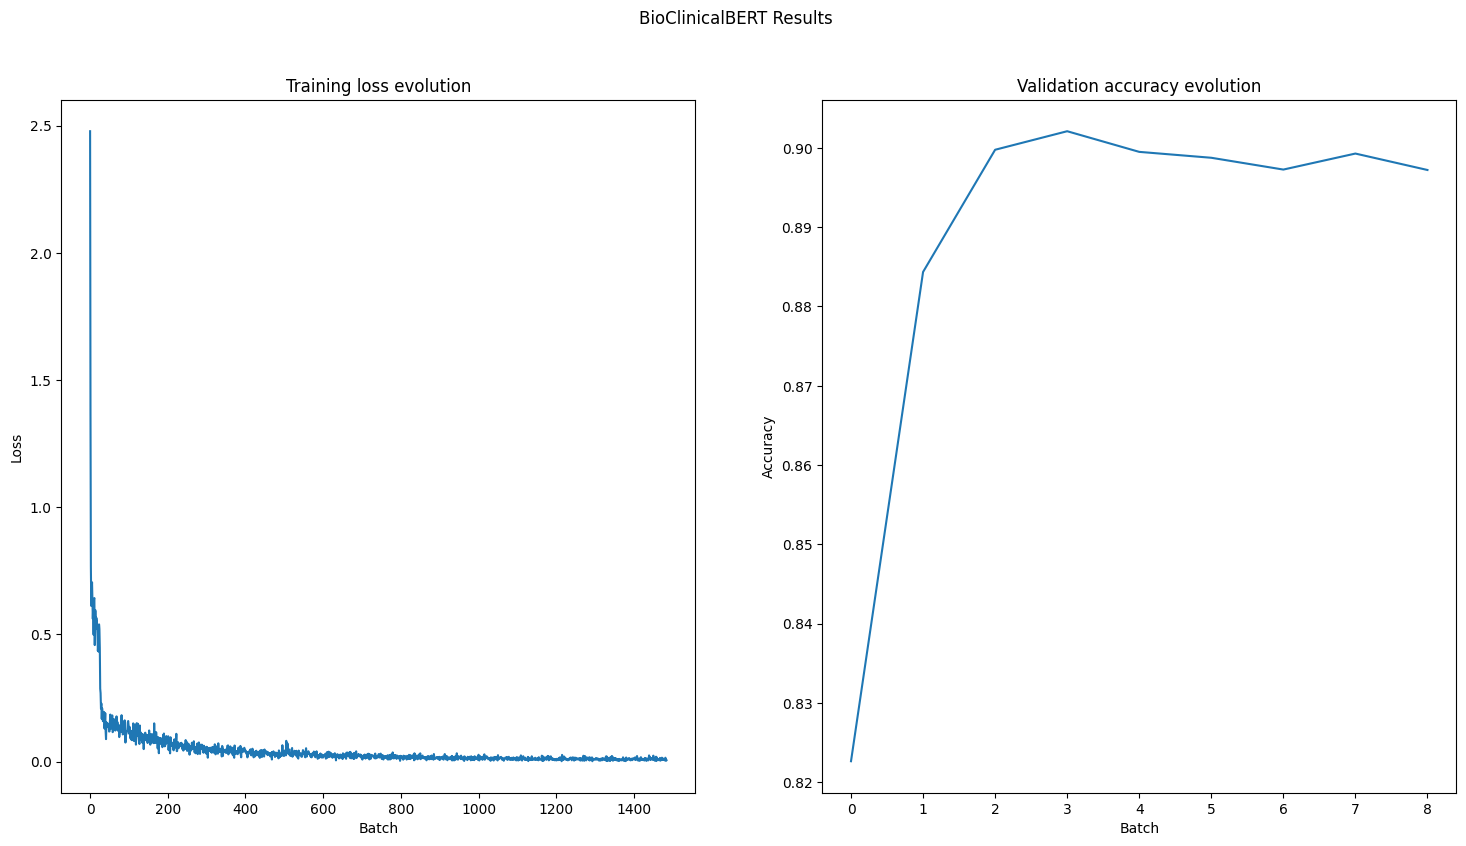

In [ ]:
# plot training performance
results_figure = plt.figure(figsize=(18,9))
ax_train = results_figure.add_subplot(1, 2, 1)
ax_val = results_figure.add_subplot(1, 2, 2)
results_figure.suptitle('BioClinicalBERT Results')
ax_train.set_title("Training loss evolution")
ax_train.set_xlabel("Batch")
ax_train.set_ylabel("Loss")
ax_train.plot(train_loss_set)
ax_val.set_title("Validation accuracy evolution")
ax_val.set_xlabel("Batch")
ax_val.set_ylabel("Accuracy")
ax_val.plot(eval_accuracy_set)
plt.show()

## 6. Testing the model

The final step is to test the model. This step is similar to the evaluation one with the difference that the input dataset is changed.

In [ ]:
## TEST

# Put model in evaluation mode
model.eval()
# Evaluate data for one epoch
for batch in test_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    test_metrics = compute_nn_metrics(logits, label_ids)
    test_metrics_imbalanced = compute_nn_metrics(logits, label_ids, imbalanced=True)
    test_metrics_per_entity = compute_nn_metrics(logits, label_ids, entity_level=True)
print('Metrics report in Test (with "O" class):\n{}'.format(test_metrics))
print('Metrics report in Test (w/o "O" class):\n{}'.format(test_metrics_imbalanced))
print('Metrics report in Test per entity:\n{}'.format(test_metrics_per_entity))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['O', 'B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['B-RAREDISEASE', 'I-RAREDISEASE', 'B-DISEASE', 'I-DISEASE', 'B-SIGN', 'I-SIGN', 'B-SYMPTOM', 'I-SYMPTOM'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Metrics report in Test (with "O" class):
               precision    recall  f1-score   support

            O     0.9521    0.9578    0.9550     15671
B-RAREDISEASE     0.8685    0.7389    0.7985       429
I-RAREDISEASE     0.8756    0.7605    0.8140      1758
    B-DISEASE     0.5500    0.5455    0.5477       242
    I-DISEASE     0.4797    0.5108    0.4948       695
       B-SIGN     0.6507    0.7233    0.6851       412
       I-SIGN     0.6639    0.7132    0.6877      1775
    B-SYMPTOM     0.6667    0.7826    0.7200        46
    I-SYMPTOM     0.5765    0.4336    0.4949       113

     accuracy                         0.8893     21141
    macro avg     0.6982    0.6851    0.6886     21141
 weighted avg     0.8912    0.8893    0.8896     21141

Metrics report in Test (w/o "O" class):
               precision    recall  f1-score   support

B-RAREDISEASE     0.8685    0.7389    0.7985       429
I-RAREDISEASE     0.8756    0.7605    0.8140      1758
    B-DISEASE     0.5500    0.5455 

Scenarios:

    - I. Surface string and entity type match
    - II. System hypothesized an entity
    - III. System misses an entity
    - IV. System assigns the wrong entity type
    - V. System gets the boundaries of the surface string wrong
    - VI. System gets the boundaries and entity type wrong

MUC metrics:

    - Correct (COR) : both are the same
    - Incorrect (INC) : the output of a system and the golden annotation don’t match
    - Partial (PAR) : system and the golden annotation are somewhat “similar” but not the same
    - Missing (MIS) : a golden annotation is not captured by a system
    - Spurius (SPU) : system produces a response which doesn’t exist in the golden annotation

Four different ways to measure precision/recall/f1-score:

    - Strict: exact boundary surface string match and entity type
    - Exact: exact boundary match over the surface string, regardless of the type
    - Partial: partial boundary match over the surface string, regardless of the type
    - Type: some overlap between the system tagged entity and the gold annotation is required


In [ ]:
import logging
from collections import namedtuple
from copy import deepcopy

logging.basicConfig(
    format="%(asctime)s %(name)s %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="DEBUG",
)

Entity = namedtuple("Entity", "e_type start_offset end_offset")

class Evaluator():

    def __init__(self, true, pred, tags):
        """
        """

        if len(true) != len(pred):
            raise ValueError("Number of predicted documents does not equal true")

        self.true = true
        self.pred = pred
        self.tags = tags

        # Setup dict into which metrics will be stored.

        self.metrics_results = {
            'correct': 0,
            'incorrect': 0,
            'incorrect_type': 0,
            'incorrect_boundary': 0,
            'partial': 0,
            'missed': 0,
            'spurious': 0,
            'possible': 0,
            'actual': 0,
            'precision': 0,
            'recall': 0,
        }

        # Copy results dict to cover the four schemes.

        self.results = {
            'strict': deepcopy(self.metrics_results),
            'ent_type': deepcopy(self.metrics_results),
            'partial':deepcopy(self.metrics_results),
            'exact':deepcopy(self.metrics_results),
            }

        # Create an accumulator to store results

        self.evaluation_agg_entities_type = {e: deepcopy(self.results) for e in tags}


    def evaluate(self):

        logging.info(
            "Imported %s predictions for %s true examples",
            len(self.pred), len(self.true)
        )

        for true_ents, pred_ents in zip(self.true, self.pred):

            # Check that the length of the true and predicted examples are the
            # same. This must be checked here, because another error may not
            # be thrown if the lengths do not match.

            if len(true_ents) != len(pred_ents):
                raise ValueError("Prediction length does not match true example length")

            # Compute results for one message

            tmp_results, tmp_agg_results = compute_metrics(
                collect_named_entities(true_ents),
                collect_named_entities(pred_ents),
                self.tags
            )

            # Cycle through each result and accumulate

            # TODO: Combine these loops below:

            for eval_schema in self.results:

                for metric in self.results[eval_schema]:

                    self.results[eval_schema][metric] += tmp_results[eval_schema][metric]

            # Calculate global precision and recall

            self.results = compute_precision_recall_wrapper(self.results)

            # Aggregate results by entity type

            for e_type in self.tags:

                for eval_schema in tmp_agg_results[e_type]:

                    for metric in tmp_agg_results[e_type][eval_schema]:

                        self.evaluation_agg_entities_type[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]

                # Calculate precision recall at the individual entity level

                self.evaluation_agg_entities_type[e_type] = compute_precision_recall_wrapper(self.evaluation_agg_entities_type[e_type])

        return self.results, self.evaluation_agg_entities_type


def collect_named_entities(tokens):
    """
    Creates a list of Entity named-tuples, storing the entity type and the start and end
    offsets of the entity.
    :param tokens: a list of tags
    :return: a list of Entity named-tuples
    """

    named_entities = []
    start_offset = None
    end_offset = None
    ent_type = None

    for offset, token_tag in enumerate(tokens):

        if token_tag == 'O':
            if ent_type is not None and start_offset is not None:
                end_offset = offset - 1
                named_entities.append(Entity(ent_type, start_offset, end_offset))
                start_offset = None
                end_offset = None
                ent_type = None

        elif ent_type is None:
            ent_type = token_tag[2:]
            start_offset = offset

        elif ent_type != token_tag[2:] or (ent_type == token_tag[2:] and token_tag[:1] == 'B'):

            end_offset = offset - 1
            named_entities.append(Entity(ent_type, start_offset, end_offset))

            # start of a new entity
            ent_type = token_tag[2:]
            start_offset = offset
            end_offset = None

    # catches an entity that goes up until the last token

    if ent_type is not None and start_offset is not None and end_offset is None:
        named_entities.append(Entity(ent_type, start_offset, len(tokens)-1))

    return named_entities


def compute_metrics(true_named_entities, pred_named_entities, tags):


    eval_metrics = {'correct': 0, 'incorrect_type': 0, 'incorrect_boundary': 0, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'precision': 0, 'recall': 0}

    # overall results

    evaluation = {
        'strict': deepcopy(eval_metrics),
        'ent_type': deepcopy(eval_metrics),
        'partial': deepcopy(eval_metrics),
        'exact': deepcopy(eval_metrics)
    }

    # results by entity type

    evaluation_agg_entities_type = {e: deepcopy(evaluation) for e in tags}

    # keep track of entities that overlapped

    true_which_overlapped_with_pred = []

    # Subset into only the tags that we are interested in.
    # NOTE: we remove the tags we don't want from both the predicted and the
    # true entities. This covers the two cases where mismatches can occur:
    #
    # 1) Where the model predicts a tag that is not present in the true data
    # 2) Where there is a tag in the true data that the model is not capable of
    # predicting.

    true_named_entities = [ent for ent in true_named_entities if ent.e_type in tags]
    pred_named_entities = [ent for ent in pred_named_entities if ent.e_type in tags]

    # go through each predicted named-entity

    for pred in pred_named_entities:
        found_overlap = False

        # Check each of the potential scenarios in turn. See
        # http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/
        # for scenario explanation.

        # Scenario I: Exact match between true and pred

        if pred in true_named_entities:
            true_which_overlapped_with_pred.append(pred)
            evaluation['strict']['correct'] += 1
            evaluation['ent_type']['correct'] += 1
            evaluation['exact']['correct'] += 1
            evaluation['partial']['correct'] += 1


            # for the agg. by e_type results
            evaluation_agg_entities_type[pred.e_type]['strict']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['ent_type']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['exact']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['partial']['correct'] += 1


        else:

            # check for overlaps with any of the true entities

            for true in true_named_entities:

                pred_range = range(pred.start_offset, pred.end_offset)
                true_range = range(true.start_offset, true.end_offset)

                # Scenario IV: Offsets match, but entity type is wrong

                if true.start_offset == pred.start_offset and pred.end_offset == true.end_offset \
                        and true.e_type != pred.e_type:

                    # overall results
                    # evaluation['strict']['incorrect'] += 1
                    evaluation['strict']['incorrect_type'] += 1
                    evaluation['ent_type']['incorrect'] += 1
                    evaluation['partial']['correct'] += 1
                    evaluation['exact']['correct'] += 1


                    # aggregated by entity type results
                    # evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                    evaluation_agg_entities_type[true.e_type]['strict']['incorrect_type'] += 1
                    evaluation_agg_entities_type[true.e_type]['ent_type']['incorrect'] += 1
                    evaluation_agg_entities_type[true.e_type]['partial']['correct'] += 1
                    evaluation_agg_entities_type[true.e_type]['exact']['correct'] += 1
                    # evaluation_agg_entities_type[true.e_type]['partial_type']['incorrect'] += 1

                    true_which_overlapped_with_pred.append(true)
                    found_overlap = True

                    break

                # check for an overlap i.e. not exact boundary match, with true entities

                elif find_overlap(true_range, pred_range):

                    true_which_overlapped_with_pred.append(true)

                    # Scenario V: There is an overlap (but offsets do not match
                    # exactly), and the entity type is the same.
                    # 2.1 overlaps with the same entity type

                    if pred.e_type == true.e_type:

                        # overall results
                        # evaluation['strict']['incorrect'] += 1
                        evaluation['strict']['incorrect_boundary'] += 1
                        evaluation['ent_type']['correct'] += 1
                        evaluation['partial']['partial'] += 1
                        evaluation['exact']['incorrect'] += 1

                        # aggregated by entity type results
                        # evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['strict']['incorrect_boundary'] += 1
                        evaluation_agg_entities_type[true.e_type]['ent_type']['correct'] += 1
                        evaluation_agg_entities_type[true.e_type]['partial']['partial'] += 1
                        evaluation_agg_entities_type[true.e_type]['exact']['incorrect'] += 1


                        found_overlap = True

                        break

                    # Scenario VI: Entities overlap, but the entity type is
                    # different.

                    else:
                        # overall results
                        evaluation['strict']['incorrect'] += 1
                        evaluation['ent_type']['incorrect'] += 1
                        evaluation['partial']['partial'] += 1
                        evaluation['exact']['incorrect'] += 1
                        # evaluation['partial_type']['incorrect'] += 1

                        # aggregated by entity type results
                        # Results against the true entity

                        evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['partial']['partial'] += 1
                        evaluation_agg_entities_type[true.e_type]['ent_type']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['exact']['incorrect'] += 1
                        # evaluation_agg_entities_type[true.e_type]['partial_type']['incorrect'] += 1

                        # Results against the predicted entity

                        # evaluation_agg_entities_type[pred.e_type]['strict']['spurious'] += 1

                        found_overlap = True

                        break

            # Scenario II: Entities are spurious (i.e., over-generated).

            if not found_overlap:

                # Overall results

                evaluation['strict']['spurious'] += 1
                evaluation['ent_type']['spurious'] += 1
                evaluation['partial']['spurious'] += 1
                evaluation['exact']['spurious'] += 1

                # Aggregated by entity type results

                # NOTE: when pred.e_type is not found in tags
                # or when it simply does not appear in the test set, then it is
                # spurious, but it is not clear where to assign it at the tag
                # level. In this case, it is applied to all target_tags
                # found in this example. This will mean that the sum of the
                # evaluation_agg_entities will not equal evaluation.

                # for true in tags:

                #     evaluation_agg_entities_type[true]['strict']['spurious'] += 1
                #     evaluation_agg_entities_type[true]['ent_type']['spurious'] += 1
                #     evaluation_agg_entities_type[true]['partial']['spurious'] += 1
                #     evaluation_agg_entities_type[true]['exact']['spurious'] += 1


                evaluation_agg_entities_type[pred.e_type]['strict']['spurious'] += 1
                evaluation_agg_entities_type[pred.e_type]['ent_type']['spurious'] += 1
                evaluation_agg_entities_type[pred.e_type]['partial']['spurious'] += 1
                evaluation_agg_entities_type[pred.e_type]['exact']['spurious'] += 1

    # Scenario III: Entity was missed entirely.

    for true in true_named_entities:
        if true in true_which_overlapped_with_pred:
            continue
        else:
            # overall results
            evaluation['strict']['missed'] += 1
            evaluation['ent_type']['missed'] += 1
            evaluation['partial']['missed'] += 1
            evaluation['exact']['missed'] += 1

            # for the agg. by e_type
            evaluation_agg_entities_type[true.e_type]['strict']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['ent_type']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['partial']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['exact']['missed'] += 1

    # Compute 'possible', 'actual' according to SemEval-2013 Task 9.1 on the
    # overall results, and use these to calculate precision and recall.

    for eval_type in evaluation:
        evaluation[eval_type] = compute_actual_possible(evaluation[eval_type])

    # Compute 'possible', 'actual', and precision and recall on entity level
    # results. Start by cycling through the accumulated results.

    for entity_type, entity_level in evaluation_agg_entities_type.items():

        # Cycle through the evaluation types for each dict containing entity
        # level results.

        for eval_type in entity_level:

            evaluation_agg_entities_type[entity_type][eval_type] = compute_actual_possible(
                entity_level[eval_type]
            )

    return evaluation, evaluation_agg_entities_type


def find_overlap(true_range, pred_range):
    """Find the overlap between two ranges
    Find the overlap between two ranges. Return the overlapping values if
    present, else return an empty set().
    Examples:
    >>> find_overlap((1, 2), (2, 3))
    2
    >>> find_overlap((1, 2), (3, 4))
    set()
    """

    true_set = set(true_range)
    pred_set = set(pred_range)

    overlaps = true_set.intersection(pred_set)

    return overlaps


def compute_actual_possible(results):
    """
    Takes a result dict that has been output by compute metrics.
    Returns the results dict with actual, possible populated.
    When the results dicts is from partial or ent_type metrics, then
    partial_or_type=True to ensure the right calculation is used for
    calculating precision and recall.
    """

    correct = results['correct']
    incorrect = results['incorrect']
    partial = results['partial']
    missed = results['missed']
    spurious = results['spurious']

    # Possible: number annotations in the gold-standard which contribute to the
    # final score

    possible = correct + incorrect + partial + missed

    # Actual: number of annotations produced by the NER system

    actual = correct + incorrect + partial + spurious

    results["actual"] = actual
    results["possible"] = possible

    return results


def compute_precision_recall(results, partial_or_type=False):
    """
    Takes a result dict that has been output by compute metrics.
    Returns the results dict with precison and recall populated.
    When the results dicts is from partial or ent_type metrics, then
    partial_or_type=True to ensure the right calculation is used for
    calculating precision and recall.
    """

    actual = results["actual"]
    possible = results["possible"]
    partial = results['partial']
    correct = results['correct']

    if partial_or_type:
        precision = (correct + partial) / actual if actual > 0 else 0
        recall = (correct + partial) / possible if possible > 0 else 0

    else:
        precision = correct / actual if actual > 0 else 0
        recall = correct / possible if possible > 0 else 0

    results["precision"] = precision
    results["recall"] = recall

    return results


def compute_precision_recall_wrapper(results):
    """
    Wraps the compute_precision_recall function and runs on a dict of results
    """

    results_a = {key: compute_precision_recall(value, True) for key, value in results.items() if
                 key in ['partial', 'ent_type']}
    results_b = {key: compute_precision_recall(value) for key, value in results.items() if
                 key in ['strict', 'exact']}

    results = {**results_a, **results_b}

    return results

In [ ]:
inputs_idxs = b_input_ids.to('cpu').numpy()
inputs_idxs = [[i for i in sentence if i != 0] for sentence in inputs_idxs]
inputs_idxs = [tokenizer.convert_ids_to_tokens(sentence) for sentence in inputs_idxs]
pred_flat = np.argmax(logits, axis=2)
pred_sym = [[tags_metrics[l-1] for l in sentence if l != 0] for sentence in pred_flat]
true_flags = [[tags_metrics[l-1] for l in sentence if l != 0] for sentence in label_ids]
pred_flags = []

for sp, st in zip(pred_sym, true_flags):
    limit = len(st)
    new = sp[:limit]
    pred_flags.append(new)

print('Labels and sentences created')

Labels and sentences created


In [ ]:
import random

random.seed(13)
result_examples_idx = [667]
result_examples_y_gold = list()
result_examples_y_pred = list()
original_sentences = list()

for idx in result_examples_idx:
    result_examples_y_gold.append(true_flags[idx])
    result_examples_y_pred.append(pred_flags[idx])
    original_sentences.append(inputs_idxs[idx])

itr = 0
for g, p, s in zip(result_examples_y_gold, result_examples_y_pred, original_sentences):
    assert len(g) == len(p), 'Results does not seem to be the same'
    print('Sentence Nr: ', result_examples_idx[itr])
    original_s = pd.Series(s, name='WORD')
    df = pd.DataFrame(original_s)
    df['GOLD'] = g
    df['PRED'] = p
    print(df)
    itr += 1
    print()

Sentence Nr:  667
            WORD           GOLD           PRED
0             re  B-RAREDISEASE  B-RAREDISEASE
1          ##tro  I-RAREDISEASE  I-RAREDISEASE
2          ##per  I-RAREDISEASE  I-RAREDISEASE
3          ##ito  I-RAREDISEASE  I-RAREDISEASE
4          ##nea  I-RAREDISEASE  I-RAREDISEASE
5            ##l  I-RAREDISEASE  I-RAREDISEASE
6             fi  I-RAREDISEASE  I-RAREDISEASE
7          ##bro  I-RAREDISEASE  I-RAREDISEASE
8          ##sis  I-RAREDISEASE  I-RAREDISEASE
9             is              O              O
10             a              O              O
11          rare              O              O
12  inflammatory      B-DISEASE      B-DISEASE
13      disorder      I-DISEASE      I-DISEASE
14            in              O              O
15         which              O              O
16      abnormal              O              O
17     formation              O              O
18            of              O              O
19         fiber              O           

In [ ]:
if allTypes:
    test_labels = ['DISEASE', 'RAREDISEASE', 'SYMPTOM', 'SIGN']
else:
    test_labels = ['RAREDISEASE', 'SIGN-SYM']

test_to_use_gold = result_examples_y_gold
test_to_use_pred = result_examples_y_pred

evaluator_examples = Evaluator(test_to_use_gold, test_to_use_pred, test_labels)
results_examples, results_agg_examples = evaluator_examples.evaluate()

print('## OVERALL RESULTS')
for item in results_examples.keys():
    print('\tEvaluation Metric: ', item)
    print('\t', results_examples[item])
print('## RESULTS AT ENTITY LEVEL')
for entity in results_agg_examples.keys():
    print('Entity: ', entity)
    for item in results_agg_examples[entity].keys():
        print('\tEvaluation Metric: ', item)
        print('\t', results_agg_examples[entity][item])

## OVERALL RESULTS
	Evaluation Metric:  ent_type
	 {'correct': 3, 'incorrect': 0, 'partial': 0, 'missed': 4, 'spurious': 0, 'possible': 7, 'actual': 3, 'precision': 1.0, 'recall': 0.42857142857142855}
	Evaluation Metric:  partial
	 {'correct': 3, 'incorrect': 0, 'partial': 0, 'missed': 4, 'spurious': 0, 'possible': 7, 'actual': 3, 'precision': 1.0, 'recall': 0.42857142857142855}
	Evaluation Metric:  strict
	 {'correct': 3, 'incorrect': 0, 'partial': 0, 'missed': 4, 'spurious': 0, 'possible': 7, 'actual': 3, 'precision': 1.0, 'recall': 0.42857142857142855}
	Evaluation Metric:  exact
	 {'correct': 3, 'incorrect': 0, 'partial': 0, 'missed': 4, 'spurious': 0, 'possible': 7, 'actual': 3, 'precision': 1.0, 'recall': 0.42857142857142855}
## RESULTS AT ENTITY LEVEL
Entity:  DISEASE
	Evaluation Metric:  ent_type
	 {'correct': 1, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'possible': 1, 'actual': 1, 'precision': 1.0, 'recall': 1.0}
	Evaluation Metric:  partial
	 {'correct': 1, 'in

In [ ]:
evaluator_all = Evaluator(true_flags, pred_flags, test_labels)
results_all, results_agg_all = evaluator_all.evaluate()

print('## OVERALL RESULTS')
for item in results_all.keys():
    print('\tEvaluation Metric: ', item)
    print('\t', results_all[item])
print('## RESULTS AT ENTITY LEVEL')
for entity in results_agg_all.keys():
    print('Entity: ', entity)
    for item in results_agg_all[entity].keys():
        print('\tEvaluation Metric: ', item)
        print('\t', results_agg_all[entity][item])

## OVERALL RESULTS
	Evaluation Metric:  ent_type
	 {'correct': 867, 'incorrect': 191, 'incorrect_type': 0, 'incorrect_boundary': 0, 'partial': 0, 'missed': 185, 'spurious': 216, 'possible': 1243, 'actual': 1274, 'precision': 0.6805337519623234, 'recall': 0.6975060337892196}
	Evaluation Metric:  partial
	 {'correct': 890, 'incorrect': 0, 'incorrect_type': 0, 'incorrect_boundary': 0, 'partial': 168, 'missed': 185, 'spurious': 216, 'possible': 1243, 'actual': 1274, 'precision': 0.8304552590266876, 'recall': 0.8511665325824618}
	Evaluation Metric:  strict
	 {'correct': 743, 'incorrect': 44, 'incorrect_type': 147, 'incorrect_boundary': 124, 'partial': 0, 'missed': 185, 'spurious': 216, 'possible': 972, 'actual': 1003, 'precision': 0.7407776669990029, 'recall': 0.76440329218107}
	Evaluation Metric:  exact
	 {'correct': 890, 'incorrect': 168, 'incorrect_type': 0, 'incorrect_boundary': 0, 'partial': 0, 'missed': 185, 'spurious': 216, 'possible': 1243, 'actual': 1274, 'precision': 0.69858712715

In [ ]:
print(len(true_flags))
print(len(pred_flags))
print(len(inputs_idxs))

tokens = [item for sublist in inputs_idxs for item in sublist]
true = [item for sublist in true_flags for item in sublist]
pred = [item for sublist in pred_flags for item in sublist]
BioClinicalBERT_Error_Analysis_20230510 = pd.DataFrame(list(zip(tokens, true, pred)), columns =['tokens', 'true', 'pred'])
BioClinicalBERT_Error_Analysis_20230510.to_excel('/content/drive/My Drive/Colab Notebooks/ner/data/gold_nlp4rare_corpus_new/BioClinicalBERT_Error_Analysis_20230510.xlsx', sheet_name = 'Sheet1')


808
808
808
